<a href="https://colab.research.google.com/github/NearANDfar13/NLP_Winter_2024/blob/main/Final_Notebooks_San_Fran/NAA_San_Fran_NER_ImpressoAPI_Map_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/NearANDfar13/NLP_Winter_2024.git

Cloning into 'NLP_Winter_2024'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 222 (delta 31), reused 2 (delta 2), pack-reused 150 (from 1)
Receiving objects: 100% (222/222), 13.19 MiB | 16.86 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [ ]:
#From NLP class on Impresso API
#Data organizing and filtering method from NLP class
#Import the dataset "Edited Locations" for full dataset with NER results and manually edited locations
import pandas as pd

articles_df = pd.read_excel('/content/NLP_Winter_2024/NA_San_Fran_Edited_Locations.xlsx')

#Display DataFrame

articles_df = articles_df[:50]
articles_df.head()

,ID,Day,Short_Name,Full_Name,Place,Frequency,Publication,Text,Page,Link,Datengeber,NER_results,places,Edited_Places,Edited_Localities
0,3043262-5,19/04/1906,Annener Zeitung,"Annener Zeitung, verbunden mit der Annener Vol...","Annen (Witten), Witten-Annen",NaN,1885-1943,"New=York, 14 Francisco von eine gesucht. Tause...",2.,https://www.deutsche-digitale-bibliothek.de/ne...,Westfälische Wilhelms-Universität Münster Univ...,"{'ts': '2025-03-15T00:32:42Z', 'sys_id': 'ner-...","New=York, New=York, Francisco, San Frane, Form...","New York, New York, San Francisco, San Francis...",NaN
1,3118927-1,19/04/1906,Anzeiger vom Oberland,"Anzeiger vom Oberland, Tageszeitung für das Ob...",Biberach an der Riß,täglich,1870-1932,"au- Oakland als Gerücht gemeldet, daß da- amer...",2.,https://www.deutsche-digitale-bibliothek.de/ne...,Kreisarchiv des Landkreises Biberach,"{'ts': '2025-03-15T00:32:54Z', 'sys_id': 'ner-...","Oakland, Oakland, Bucht von San Franc'Sco, New...","Oakland, Oakland, San Francisco, New York, San...","Market-Street, Hauptstraße, Hotel Di Londra"
2,3118927-1,19/04/1906,Anzeiger vom Oberland,"Anzeiger vom Oberland, Tageszeitung für das Ob...",Biberach an der Riß,täglich,1870-1932,"ertappt wird, zu erschießen. ir Gf Store (CaUf...",6.,https://www.deutsche-digitale-bibliothek.de/ne...,Kreisarchiv des Landkreises Biberach,"{'ts': '2025-03-15T00:33:07Z', 'sys_id': 'ner-...","CaUfornten, Nrw, Nevada, N-w Uork, renz, renz,...","Californien, Nevada, New York, Berlin, Suisun,...",Hotels Di Londra
3,2797055-3,19/04/1906,Badische Presse,Badische Presse : Generalanzeiger der Residenz...,Karlsruhe,täglich,1890-1944,Die Marinestationen am Süllen Ozean versuchten...,4.,https://www.deutsche-digitale-bibliothek.de/ne...,Badische Landesbibliothek,"{'ts': '2025-03-15T00:33:30Z', 'sys_id': 'ner-...","Süllen Ozean, San Francisco, San Francisco, Sa...","Pazifik, San Francisco, San Francisco, San Fra...",NaN
4,2958285-4,19/04/1906,Der Beobachter,"Der Beobachter, ein Volksblatt aus Schwaben","Stuttgart, Württemberg",täglich,1833-1920,"Erdbeben in Ealifornien. New-Sjork, 18. April....",3.,https://www.deutsche-digitale-bibliothek.de/ne...,Württembergische Landesbibliothek,"{'ts': '2025-03-15T00:33:45Z', 'sys_id': 'ner-...","Ealifornien, New-Sjork, Kansas Cith, Los Angel...","Californien, New York, Kansas City, Los Angele...",NaN


In [ ]:
#Visualizaing Edited List of NER Locations as a Map
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import pandas as pd
import time
from typing import List, Tuple, Optional
import random

class GeocodingService:
    def __init__(self, user_agent: str = None, timeout: int = 10, rate_limit: float = 1.1):
        """
        Initialize the geocoding service with proper configuration.

        Args:
            user_agent: Custom user agent string (default: generated)
            timeout: Timeout for requests in seconds
            rate_limit: Time to wait between requests in seconds
        """
        if user_agent is None:
            user_agent = f"python_geocoding_script_{random.randint(1000, 9999)}"

        self.geolocator = Nominatim(
            user_agent=user_agent,
            timeout=timeout
        )
        self.rate_limit = rate_limit
        self.last_request = 0

    def _rate_limit_wait(self):
        """Implement rate limiting between requests"""
        current_time = time.time()
        time_since_last = current_time - self.last_request
        if time_since_last < self.rate_limit:
            time.sleep(self.rate_limit - time_since_last)
        self.last_request = time.time()

    def geocode_location(self, location: str, max_retries: int = 3) -> Optional[Tuple[float, float]]:
        """
        Geocode a single location with retries.

        Args:
            location: Location string to geocode
            max_retries: Maximum number of retry attempts

        Returns:
            Tuple of (latitude, longitude) or None if geocoding fails
        """
        for attempt in range(max_retries):
            try:
                self._rate_limit_wait()
                location_data = self.geolocator.geocode(location)
                if location_data:
                    return (location_data.latitude, location_data.longitude)
                return None
            except (GeocoderTimedOut, GeocoderServiceError) as e:
                if attempt == max_retries - 1:
                    print(f"Failed to geocode '{location}' after {max_retries} attempts: {e}")
                    return None
                time.sleep(2 ** attempt)  # Exponential backoff
            except Exception as e:
                print(f"Error geocoding '{location}': {e}")
                return None
        return None

    def process_locations(self, locations: str) -> List[Optional[Tuple[float, float]]]:
        """
        Process a comma-separated string of locations.

        Args:
            locations: Comma-separated string of location names

        Returns:
            List of coordinate tuples or None for failed geocoding
        """
        if pd.isna(locations) or not locations:
            return []

        location_list = [loc.strip() for loc in locations.split(',')]
        return [self.geocode_location(loc) for loc in location_list]

def geolocate_places(df: pd.DataFrame,
                    places_column: str = 'Edited_Places',
                    user_agent: str = None) -> pd.DataFrame:
    """
    Add coordinates to a DataFrame based on location names.

    Args:
        df: Input DataFrame
        places_column: Name of the column containing comma-separated location strings
        user_agent: Custom user agent string

    Returns:
        DataFrame with added 'coordinates' column
    """
    geocoder = GeocodingService(user_agent=user_agent)

    # Create a copy to avoid modifying the original DataFrame
    result_df = df.copy()

    # Process locations
    result_df['coordinates'] = result_df[places_column].apply(geocoder.process_locations)

    return result_df

# Main execution
if __name__ == "__main__":
    # Assuming articles_df is your DataFrame with a 'places' column
    # Apply geocoding to the articles DataFrame
    articles_df_with_coords = geolocate_places(
        articles_df,
        places_column='Edited_Places',
        user_agent='article_geocoding_service_v1.0'
    )

    # Update the original DataFrame with the new coordinates
    articles_df['coordinates'] = articles_df_with_coords['coordinates']

    # Display the results
    print("\nSample of geocoded locations:")
    print(articles_df[['Edited_Places', 'coordinates']].head())

    # Optional: Display some statistics
    total_locations = len(articles_df)
    successful_geocodes = articles_df['coordinates'].apply(lambda x: len([c for c in x if c is not None])).sum()
    failed_geocodes = articles_df['coordinates'].apply(lambda x: len([c for c in x if c is None])).sum()

    print(f"\nGeocoding Statistics:")
    print(f"Total locations processed: {total_locations}")
    print(f"Successfully geocoded: {successful_geocodes}")
    print(f"Failed to geocode: {failed_geocodes}")


Sample of geocoded locations:
                                       Edited_Places  \
0  New York, New York, San Francisco, San Francis...   
1  Oakland, Oakland, San Francisco, New York, San...   
2  Californien, Nevada, New York, Berlin, Suisun,...   
3  Pazifik, San Francisco, San Francisco, San Fra...   
4  Californien, New York, Kansas City, Los Angele...   

                                         coordinates  
0  [(40.7127281, -74.0060152), (40.7127281, -74.0...  
1  [(37.8044557, -122.271356), (37.8044557, -122....  
2  [(36.7014631, -118.755997), (39.5158825, -116....  
3  [(-0.703107, -120.9375), (37.7792588, -122.419...  
4  [(36.7014631, -118.755997), (40.7127281, -74.0...  

Geocoding Statistics:
Total locations processed: 50
Successfully geocoded: 1650
Failed to geocode: 37


In [ ]:
import folium
from folium import plugins
import pandas as pd
from typing import List, Tuple, Optional
from IPython.display import display

def create_location_map(df: pd.DataFrame,
                       coordinates_col: str = 'coordinates',
                       places_col: str = 'Edited_Places',
                       title_col: Optional[str] = None) -> folium.Map:
    """
    Create an interactive map with markers for all locations in the DataFrame.

    Args:
        df: DataFrame containing coordinates and place names
        coordinates_col: Name of column containing coordinates
        places_col: Name of column containing place names
        title_col: Optional column name for additional marker information

    Returns:
        folium.Map object with all locations marked
    """
    # Initialize the map
    m = folium.Map(location=[0, 0], zoom_start=2)

    # Create a MarkerCluster
    marker_cluster = plugins.MarkerCluster().add_to(m)

    # Keep track of all valid coordinates for setting bounds
    all_coords = []

    # Process each row in the DataFrame
    for idx, row in df.iterrows():
        coordinates = row[coordinates_col]
        places = row[places_col].split(',') if pd.notna(row[places_col]) else []
        title = row[title_col] if title_col and pd.notna(row[title_col]) else None

        # Skip if no coordinates
        if not coordinates:
            continue

        # Add markers for each location
        for i, (coord, place) in enumerate(zip(coordinates, places)):
            if coord is not None:  # Skip None coordinates
                lat, lon = coord
                place_name = place.strip()

                # Create popup content
                popup_content = f"<b>{place_name}</b>"
                if title:
                    popup_content += f"<br>{title}"

                # Add marker
                folium.Marker(
                    location=[lat, lon],
                    popup=popup_content,
                    tooltip=place_name
                ).add_to(marker_cluster)

                all_coords.append([lat, lon])

    # If we have coordinates, fit the map bounds to include all points
    if all_coords:
        m.fit_bounds(all_coords)

    return m

# Create and display the map
map_obj = create_location_map(articles_df)
display(map_obj)

In [ ]:
# export as excel file
articles_df.to_excel('earthquake_articles_coords.xlsx', index=False)

In [1]:
!git clone https://github.com/NearANDfar13/NLP_Winter_2024.git

Cloning into 'NLP_Winter_2024'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 240 (delta 41), reused 2 (delta 2), pack-reused 150 (from 1)
Receiving objects: 100% (240/240), 14.67 MiB | 6.91 MiB/s, done.
Resolving deltas: 100% (110/110), done.


In [2]:
#Data organizing and filtering method from NLP class
#Import the dataset "San Fran Coordinates Full"
import pandas as pd

df = pd.read_excel('/content/NLP_Winter_2024/NA_San_Fran_Coords_Full.xlsx')

#Display DataFrame 'df'
df.head()

,ID,Day,Short_Name,Full_Name,Place,pub_coordinates,Frequency,Publication,Text,Page,Link,Datengeber,NER_results,places,Edited_Places,Edited_Localities,place_coordinates
0,3043262-5,19/04/1906,Annener Zeitung,"Annener Zeitung, verbunden mit der Annener Vol...","Annen (Witten), Witten-Annen","[(51.4462436, 7.3744351), (51.4462436, 7.37443...",NaN,1885-1943,"New=York, 14 Francisco von eine gesucht. Tause...",2.,https://www.deutsche-digitale-bibliothek.de/ne...,Westfälische Wilhelms-Universität Münster Univ...,"{'ts': '2025-03-15T00:32:42Z', 'sys_id': 'ner-...","New=York, New=York, Francisco, San Frane, Form...","New York, New York, San Francisco, San Francis...",NaN,"[(40.7127281, -74.0060152), (40.7127281, -74.0..."
1,3118927-1,19/04/1906,Anzeiger vom Oberland,"Anzeiger vom Oberland, Tageszeitung für das Ob...",Biberach an der Riß,"[(48.0984413, 9.7899938)]",täglich,1870-1932,"au- Oakland als Gerücht gemeldet, daß da- amer...",2.,https://www.deutsche-digitale-bibliothek.de/ne...,Kreisarchiv des Landkreises Biberach,"{'ts': '2025-03-15T00:32:54Z', 'sys_id': 'ner-...","Oakland, Oakland, Bucht von San Franc'Sco, New...","Oakland, Oakland, San Francisco, New York, San...","Market Street, Hotel Di Londra","[(37.8044557, -122.271356), (37.8044557, -122...."
2,3118927-1,19/04/1906,Anzeiger vom Oberland,"Anzeiger vom Oberland, Tageszeitung für das Ob...",Biberach an der Riß,"[(48.0984413, 9.7899938)]",täglich,1870-1932,"ertappt wird, zu erschießen. ir Gf Store (CaUf...",6.,https://www.deutsche-digitale-bibliothek.de/ne...,Kreisarchiv des Landkreises Biberach,"{'ts': '2025-03-15T00:33:07Z', 'sys_id': 'ner-...","CaUfornten, Nrw, Nevada, N-w Uork, renz, renz,...","Californien, Nevada, New York, Berlin, Suisun,...",Hotel Di Londra,"[(36.7014631, -118.755997), (39.5158825, -116...."
3,2797055-3,19/04/1906,Badische Presse,Badische Presse : Generalanzeiger der Residenz...,Karlsruhe,"[(49.0068705, 8.4034195)]",täglich,1890-1944,Die Marinestationen am Süllen Ozean versuchten...,4.,https://www.deutsche-digitale-bibliothek.de/ne...,Badische Landesbibliothek,"{'ts': '2025-03-15T00:33:30Z', 'sys_id': 'ner-...","Süllen Ozean, San Francisco, San Francisco, Sa...","Pazifik, San Francisco, San Francisco, San Fra...",NaN,"[(-0.703107, -120.9375), (37.7792588, -122.419..."
4,2958285-4,19/04/1906,Der Beobachter,"Der Beobachter, ein Volksblatt aus Schwaben","Stuttgart, Württemberg","[(48.7784485, 9.1800132), (48.3366504, 9.09940...",täglich,1833-1920,"Erdbeben in Ealifornien. New-Sjork, 18. April....",3.,https://www.deutsche-digitale-bibliothek.de/ne...,Württembergische Landesbibliothek,"{'ts': '2025-03-15T00:33:45Z', 'sys_id': 'ner-...","Ealifornien, New-Sjork, Kansas Cith, Los Angel...","Californien, New York, Kansas City, Los Angele...",NaN,"[(36.7014631, -118.755997), (40.7127281, -74.0..."


In [14]:
#Frequency of Keywords: Localities
# How often appears "Eddy Street" in df dataset
eddy_count = df['Edited_Localities'].str.count('Eddy Street').sum()
print(f'"Eddy Street" appears {eddy_count} times in the dataset.')

# How often appears "Fort Mason" in df dataset
fort_count = df['Edited_Localities'].str.count('Fort Mason').sum()
print(f'"Fort Mason" appears {fort_count} times in the dataset.')

# How often appears "Golden Gate" in df dataset
golden_count = df['Edited_Localities'].str.count('Golden Gate').sum()
print(f'"Golden Gate" appears {golden_count} times in the dataset.')

# How often appears "Hotel Valencia" in df dataset
valencia_count = df['Edited_Localities'].str.count('Hotel Valencia').sum()
print(f'"Hotel Valencia" appears {valencia_count} times in the dataset.')

# How often appears "Lombard Street" in df dataset
lombard_count = df['Edited_Localities'].str.count('Lombard Street').sum()
print(f'"Lombard Street" appears {lombard_count} times in the dataset.')

# How often appears "Market Street" in df dataset
market_count = df['Edited_Localities'].str.count('Market Street').sum()
print(f'"Market Street" appears {market_count} times in the dataset.')

# How often appears "Münze" in df dataset
muenze_count = df['Edited_Localities'].str.count('Münze').sum()
print(f'"Münze" appears {muenze_count} times in the dataset.')

# How often appears "Nob Hill" in df dataset
nob_count = df['Edited_Localities'].str.count('Nob Hill').sum()
print(f'"Nob Hill" appears {nob_count} times in the dataset.')

# How often appears "Palace Hotel" in df dataset
palace_count = df['Edited_Localities'].str.count('Palace Hotel').sum()
print(f'"Palace Hotel" appears {palace_count} times in the dataset.')

# How often appears "Townsend Street" in df dataset
townsend_count = df['Edited_Localities'].str.count('Townsend Street').sum()
print(f'"Townsend Street" appears {townsend_count} times in the dataset.')

# How often appears "Van Ness Avenue" in df dataset
van_count = df['Edited_Localities'].str.count('Van Ness Avenue').sum()
print(f'"Van Ness Avenue" appears {van_count} times in the dataset.')


"Eddy Street" appears 3.0 times in the dataset.
"Fort Mason" appears 15.0 times in the dataset.
"Golden Gate" appears 25.0 times in the dataset.
"Hotel Valencia" appears 3.0 times in the dataset.
"Lombard Street" appears 16.0 times in the dataset.
"Market Street" appears 97.0 times in the dataset.
"Münze" appears 10.0 times in the dataset.
"Nob Hill" appears 5.0 times in the dataset.
"Palace Hotel" appears 7.0 times in the dataset.
"Townsend Street" appears 5.0 times in the dataset.
"Van Ness Avenue" appears 19.0 times in the dataset.


In [6]:
import matplotlib.pyplot as plt

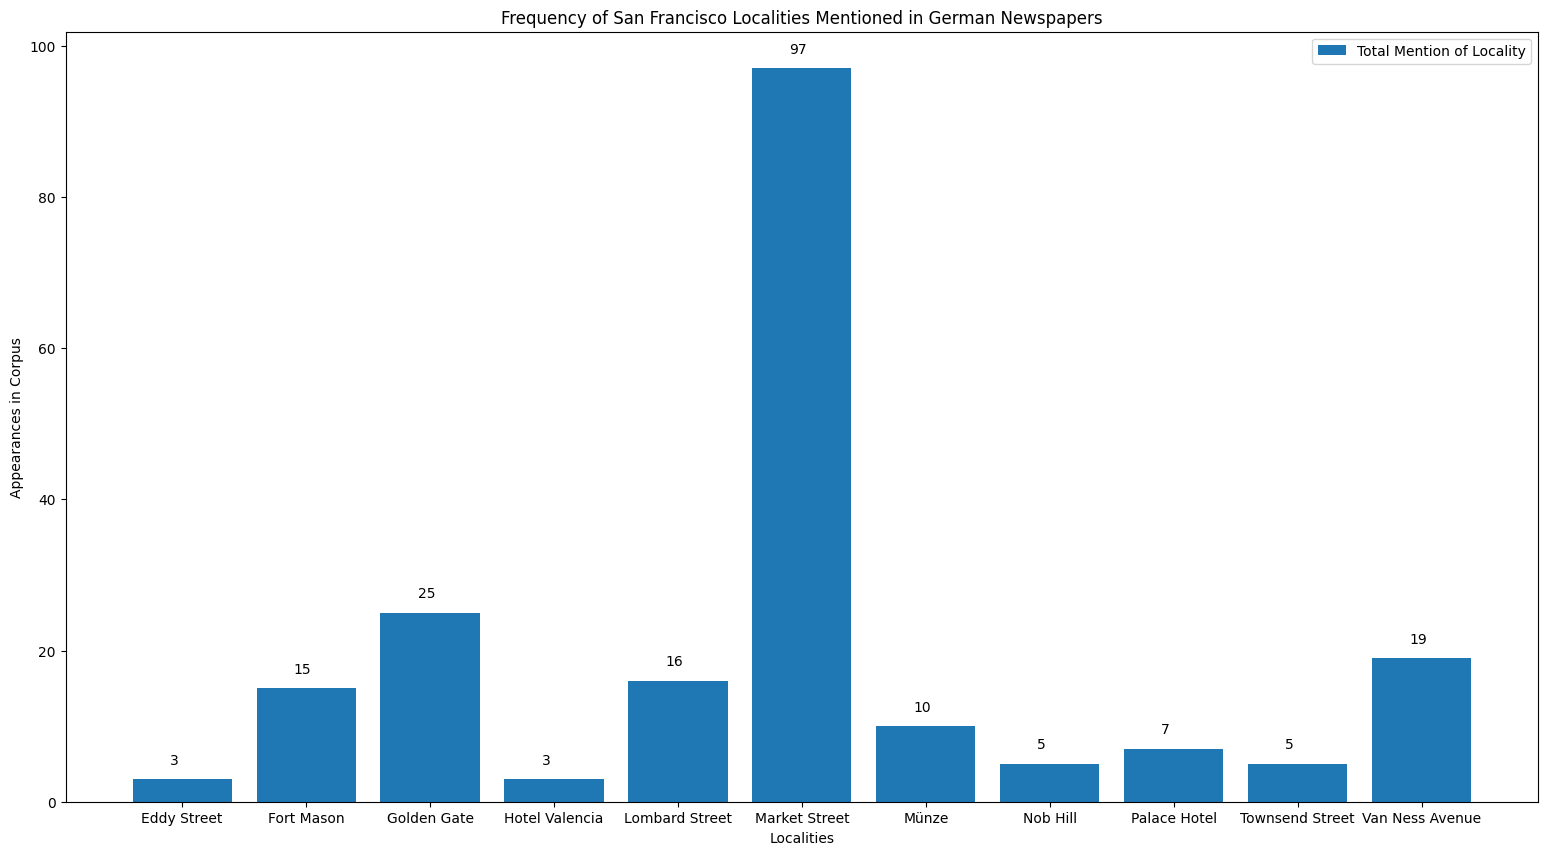

In [17]:
# Source of Code for Bar Graphs in Google Colab: https://colab.research.google.com/notebooks/charts.ipynb
# Source of Code for Bar Graph Formatting in Google Colab: https://colab.research.google.com/github/Tanu-N-Prabhu/Python/blob/master/Mastering_the_Bar_Plot_in_Python.ipynb

#Frequency of Keywords: Localities as Bar Graph
keywords_ef = ['Eddy Street', 'Fort Mason', 'Golden Gate', 'Hotel Valencia', 'Lombard Street', 'Market Street', 'Münze', 'Nob Hill', 'Palace Hotel', 'Townsend Street', 'Van Ness Avenue']
total_words_ef = [3, 15, 25, 3, 16, 97, 10, 5, 7, 5, 19]

# Declaring the figure or the plot (y, x) or (width, height)
plt.figure(figsize=[19, 10])

# Passing the parameters to the bar function, this is the main function which creates the bar plot
plt.bar(keywords_ef, total_words_ef)

# This is the location for the annotated text
i = 1.0
j = 2
# Annotating the bar plot with the values (total count)
for i in range(len(keywords_ef)):
    plt.annotate(total_words_ef[i], (-0.1 + i, total_words_ef[i] + j))

# Namimg the x and y axis
plt.xlabel('Localities')
plt.ylabel('Appearances in Corpus')

# Creating the legend of the bars in the plot
plt.legend(labels = ['Total Mention of Locality'])
# Giving the tilte for the plot
plt.title("Frequency of San Francisco Localities Mentioned in German Newspapers")

plt.show()